<a href="https://colab.research.google.com/github/seacatgm/-/blob/main/Computer%20vision/%D0%A1%D0%B5%D0%B3%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%86%D0%B8%D1%8F%20%D0%B8%D0%B7%D0%BE%D0%B1%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B9/%D0%A1%D0%B5%D0%B3%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%86%D0%B8%D1%8F_%D1%81%D0%B0%D0%BC%D0%BE%D0%BB%D0%B5%D1%82%D1%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Библиотеки

In [181]:
from tensorflow.keras.models import Model # Импортируем модели keras: Model
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization # Импортируем стандартные слои keras
from tensorflow.keras import backend as K # Импортируем модуль backend keras'а
from tensorflow.keras.optimizers import Adam # Импортируем оптимизатор Adam
from tensorflow.keras import utils # Импортируем модуль utils библиотеки tensorflow.keras для получения OHE-представления
from google.colab import files # Импортируем Модуль files для работы с файлами
import matplotlib.pyplot as plt # Импортируем модуль pyplot библиотеки matplotlib для построения графиков
from tensorflow.keras.preprocessing import image # Импортируем модуль image для работы с изображениями
import numpy as np # Импортируем библиотеку numpy
from sklearn.model_selection import train_test_split
import time
import random
import os # Импортируем библиотеку os для раоты с фаловой системой
from PIL import Image # импортируем модель Image для работы с изображениями

In [182]:
from google.colab import drive # Подключаем гугл-диск
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Загрузка изображений

In [183]:
# Глобальные параметры
img_width = 176 # Ширина уменьшенной картинки 
img_height = 320 # Высота уменьшенной картинки 
num_classes = 2 # Задаем количество классов на изображении
directory = '/content/drive/My Drive/neuro/base/Самолеты сегментация/' # Указываем путь к обучающей выборке с оригинальными изображения
train_directory = 'Airplane' # Название папки с файлами обучающей выборки
val_directory = 'Segment' # Название папки с файлами проверочной выборки

## Оригинальные изображения

In [184]:
images_airplane = [] # Создаем пустой список для хранений оригинльных изображений обучающей выборки

cur_time = time.time() # Засекаем текущее время
for filename in sorted(os.listdir(directory + train_directory)): # Проходим по всем файлам в каталоге по указанному пути     
    images_airplane.append(image.load_img(os.path.join(directory + train_directory,filename),
                                       target_size=(img_width, img_height))) # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size                                                      
print ('Обучающая выборка загружена. Время загрузки: ', time.time() - cur_time, 'c', sep='') # Отображаем время загрузки изображений обучающей выборки

Обучающая выборка загружена. Время загрузки: 24.108945608139038c


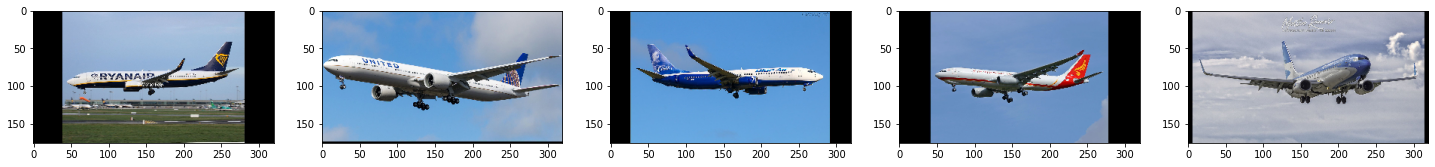

In [185]:
n = 5 # Количество выводимых случайных изображений
fig, axs = plt.subplots(1, n, figsize=(25, 5)) # Создаем полотно из n графиков
for i in range(n): # Выводим в цикле n случайных изображений
  img = random.choice(images_airplane) # Выбираем случайное фото для отображения
  axs[i].imshow(img) # Отображаем фото
plt.show() #Показываем изображения

## Сегментированные изображения

In [186]:
segments_airplane = [] # Создаем пустой список для хранений оригинальных изображений обучающей выборки

cur_time = time.time() # Засекаем текущее время
for filename in sorted(os.listdir(directory + val_directory)): # Проходим по всем файлам в каталоге по указанному пути     
    segments_airplane.append(image.load_img(os.path.join(directory + val_directory,filename),
                                       target_size=(img_width, img_height))) # Читаем очередное изображение и добавляем его в список изображения с указанным target_size                                                      
print ('Обучающая выборка загружена. Время загрузки: ', time.time() - cur_time, 'c', sep='') # Отображаем время загрузки картинок обучающей выборки

Обучающая выборка загружена. Время загрузки: 21.64382529258728c


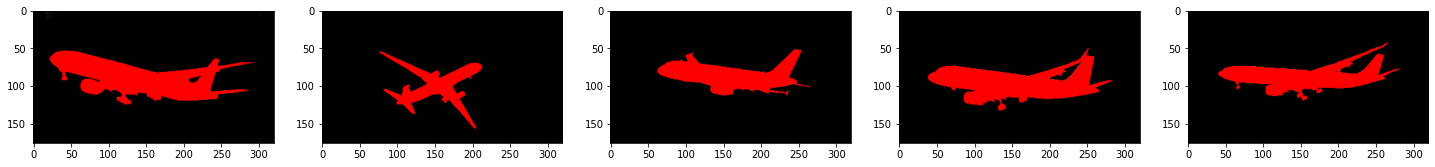

In [187]:
n = 5 # Количество выводимых случайных изображений
fig, axs = plt.subplots(1, n, figsize=(25, 5)) # Создаем полотно из n графиков
for i in range(n): # Выводим в цикле n случайных изображений
  img = random.choice(segments_airplane) # Выбираем случайное фото для отображения
  axs[i].imshow(img) # Отображаем фото
plt.show() # Показываем изображения

## Аугментация

In [188]:
import albumentations as A
# Функция приниимает изображение и маску, возвращает агументировное изображение и маску
def aug(image, mask):
  transform = A.Compose([A.HorizontalFlip(p=1), A.Blur(blur_limit= 3, p = 0.7)]) # Используем отражение по горизонтали и размытие
  transformed = transform(image=image, mask=mask) # получаем словарь агументированных изображений
  transformed_image = transformed['image'] # по ключу преедаем в переменную
  transformed_mask = transformed['mask'] # по ключу преедаем в переменную
  return transformed_image, transformed_mask # возвращаем агументированое изображение и маску

In [189]:
count = 200 # количество изображений для агументации
plane_aug, segment_aug = [], [] # здеь сохраним агументированные изображения
for i in range(count): # столько раз сколько нужно изображений
  number_random = random.randint(0,1000) # генерируем случайный
  img2 = np.array(images_airplane[number_random]) # берем случайное изображение, функция работает с numpy массивом поэтому переовдим в него
  mask2 = np.array(segments_airplane[number_random]) # берем маску для случайного изображения, функция работает с numpy массивом поэтому переовдим в него
  aug_img2 = Image.fromarray(aug(img2, mask2)[0]) # переводим агументированное изображение из массива numpy обратно в Image
  aug_mask2 = Image.fromarray(aug(img2, mask2)[1]) # переводим агументированное изображение из массива numpy обратно в Image
  plane_aug.append(aug_img2) # добавляем в список агументировнное изображение
  segment_aug.append(aug_mask2) # добавляем в список маску к нему

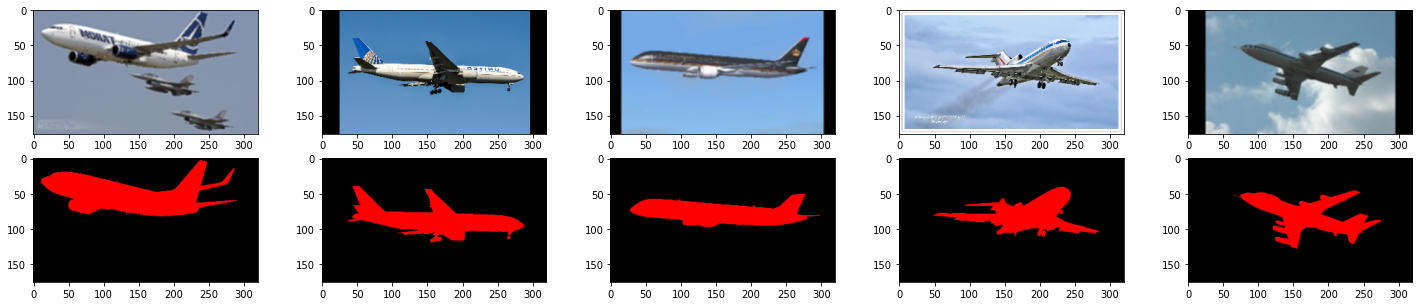

In [190]:
n = 5 # Количество выводимых случайных изображений
fig, axs = plt.subplots(2, n, figsize=(25, 5)) # Создаем полотно из n графиков
for i in range(n): # Выводим в цикле n случайных изображений
  number_random = random.randint(0,count)
  img_plane_aug = plane_aug[number_random] # Выбираем случайное фото для отображения
  img_seg_aug = segment_aug[number_random] # Выбираем случайную маску для отображения
  axs[0,i].imshow(img_plane_aug) # Отображаем фото
  axs[1,i].imshow(img_seg_aug)
plt.show() # Показываем изображения

In [191]:
images_airplane = images_airplane + plane_aug # добавляем к нашей изначальной выборки агументированные изображения
segments_airplane = segments_airplane + segment_aug # добавляем к нашей изначальной выборки агументированные изображения
print(len(images_airplane)) # посмотрим размер выборки изображений
print(len(segments_airplane)) # сверим с размером масок

1200
1200


# Создание выборки

In [192]:
# Функция преобразования пикселя сегментированного изображения в индекс (2 класса)
def color2index(color):
    index=0
    if (color[0] + color[1] + color[2]) > 1  : index = 1 # самолет    
    return index  

In [193]:
# Функция преобразования индекса в цвет пикселя
def index2color(index2):
  index = np.argmax(index2) # Получаем индекс максимального элемента
  color=[]
  if   index == 0: color = [0, 0, 0]  # фон
  elif index == 1: color = [255, 0, 0]  # самолет
  return color 

In [194]:
# Функция перевода индекса пикслея в to_categorical
def rgbToohe(y, num_classes): 
  y2 = y.copy() # Создаем копию входного массива
  y = y.reshape(y.shape[0] * y.shape[1], 3) # Решейпим в двумерный массив
  yt = [] # Создаем пустой лист
  for i in range(len(y)): # Проходим по всем трем каналам изображения
    yt.append(utils.to_categorical(color2index(y[i]), num_classes=num_classes)) # Переводим пиксели в индексы и преобразуем в OHE
  yt = np.array(yt) # Преобразуем в numpy
  yt = yt.reshape(y2.shape[0], y2.shape[1], num_classes) # Решейпим к исходныму размеру
  return yt # Возвращаем сформированный массив

In [195]:
# Функция формирования yTrain
def yt_prep(data, num_classes):
  yTrain = [] # Создаем пустой список под карты сегметации
  for seg in data: # Пробегаем по всем файлам набора с сегминтированными изображениями
    y = image.img_to_array(seg) # Переводим изображение в numpy-массив размерностью: высота - ширина - количество каналов
    y = rgbToohe(y, num_classes) # Получаем OHE-представление сформированного массива
    yTrain.append(y) # Добавляем очередной элемент в yTrain
    if len(yTrain) % 100 == 0: # Каждые 100 шагов
      print(len(yTrain)) # Выводим количество обработанных изображений
  return np.array(yTrain) # Возвращаем сформированный yTrain

In [196]:
xTrain = [] # Создаем пустой список под обучающую выборку
for img in images_airplane: 
    x = image.img_to_array(img) # Переводим изображение в numpy-массив размерностью: высота - ширина - количество каналов
    xTrain.append(x) # Добавляем очередной элемент в xTrain
xTrain = np.array(xTrain) # Переводим в numpy
print(xTrain.shape) # Размерность обучающей выборки

(1200, 176, 320, 3)


In [197]:
cur_time = time.time() # Засекаем время
yTrain = yt_prep(segments_airplane, num_classes) # Получаем yTrain
print('Время обработки: ', round(time.time() - cur_time, 2),'c') # Выводим результат

100
200
300
400
500
600
700
800
900
1000
1100
1200
Время обработки:  705.09 c


In [198]:
x_train, x_val, y_train, y_val = train_test_split(xTrain, yTrain, test_size = 0.1) # делим выборки на обучающую и тестовую

In [199]:
# проверим размеры выборок
print('x_train shape    ', x_train.shape)
print('x_val shape      ', x_val.shape)
print('y_train shape    ', y_train.shape)
print('y_val shape      ', y_val.shape)

x_train shape     (1080, 176, 320, 3)
x_val shape       (120, 176, 320, 3)
y_train shape     (1080, 176, 320, 2)
y_val shape       (120, 176, 320, 2)


# Создание модели

## Unet

In [200]:
#  Собственная функция метрики, обрабатывающая пересечение двух областей

def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

In [201]:
'''
  Функция создания сети
    Входные параметры:
    - num_classes - количество классов
    - input_shape - размерность карты сегментации
'''
def unet(num_classes = 2, input_shape= (176, 320, 3)):
    img_input = Input(input_shape)                                         # Создаем входной слой с размерностью input_shape

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input) # Добавляем Conv2D-слой с 64-фильтрами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)         # Добавляем Conv2D-слой с 64-фильтрами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_1_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_1_out

    x = MaxPooling2D()(block_1_out)                                        # Добавляем слой MaxPooling2D

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)        # Добавляем Conv2D-слой с 128-фильтрами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)        # Добавляем Conv2D-слой с 128-фильтрами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_2_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_2_out

    x = MaxPooling2D()(block_2_out)                                        # Добавляем слой MaxPooling2D

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)        # Добавляем Conv2D-слой с 256-фильтрами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)        # Добавляем Conv2D-слой с 256-фильтрами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)        # Добавляем Conv2D-слой с 256-фильтрами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_3_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_3_out

    x = MaxPooling2D()(block_3_out)                                        # Добавляем слой MaxPooling2D

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)        # Добавляем Conv2D-слой с 512-фильтрами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)        # Добавляем Conv2D-слой с 256-фильтрами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)        # Добавляем Conv2D-слой с 256-фильтрами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_4_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_4_out
    x = block_4_out 

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)    # Добавляем слой Conv2DTranspose с 256-фильтрами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = concatenate([x, block_3_out])                                      # Объединем текущий слой со слоем block_3_out
    x = Conv2D(256, (3, 3), padding='same')(x)                             # Добавляем слой Conv2D с 256-фильтрами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same')(x)                             # Добавляем слой Conv2D с 256-фильтрами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)    # Добавляем слой Conv2DTranspose с 128-фильтрами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = concatenate([x, block_2_out])                                      # Объединем текущий слой со слоем block_2_out
    x = Conv2D(128, (3, 3), padding='same')(x)                             # Добавляем слой Conv2D с 128-фильтрами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same')(x)                             # Добавляем слой Conv2D с 128-фильтрами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)     # Добавляем слой Conv2DTranspose с 64-фильтрами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = concatenate([x, block_1_out])                                      # Объединем текущий слой со слоем block_1_out
    x = Conv2D(64, (3, 3), padding='same')(x)                              # Добавляем слой Conv2D с 64-фильтрами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same')(x)                              # Добавляем слой Conv2D с 64-фильтрами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)  # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов

    model = Model(img_input, x)                                            # Создаем модель с входом 'img_input' и выходом 'x'

    # Компилируем модель 
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    
    return model # Возвращаем сформированную модель

In [202]:
modelAir = unet(num_classes, (img_width, img_height, 3)) # Создаем модель
history = modelAir.fit(x_train, y_train, epochs=30, batch_size=16, validation_data = (x_val, y_val)) # Обучаем модель


Epoch 1/30
68/68 [==============================] - 28s 379ms/step - loss: 0.3208 - dice_coef: 0.8249 - val_loss: 41.8903 - val_dice_coef: 0.1969
Epoch 2/30
68/68 [==============================] - 24s 356ms/step - loss: 0.1745 - dice_coef: 0.9153 - val_loss: 0.4188 - val_dice_coef: 0.8205
Epoch 3/30
68/68 [==============================] - 24s 356ms/step - loss: 0.1794 - dice_coef: 0.9073 - val_loss: 0.9806 - val_dice_coef: 0.7148
Epoch 4/30
68/68 [==============================] - 24s 356ms/step - loss: 0.1519 - dice_coef: 0.9235 - val_loss: 0.1661 - val_dice_coef: 0.8995
Epoch 5/30
68/68 [==============================] - 24s 356ms/step - loss: 0.1452 - dice_coef: 0.9284 - val_loss: 0.1402 - val_dice_coef: 0.9237
Epoch 6/30
68/68 [==============================] - 24s 357ms/step - loss: 0.1465 - dice_coef: 0.9298 - val_loss: 0.1498 - val_dice_coef: 0.9142
Epoch 7/30
68/68 [==============================] - 24s 357ms/step - loss: 0.1428 - dice_coef: 0.9241 - val_loss: 0.8285 - val_di

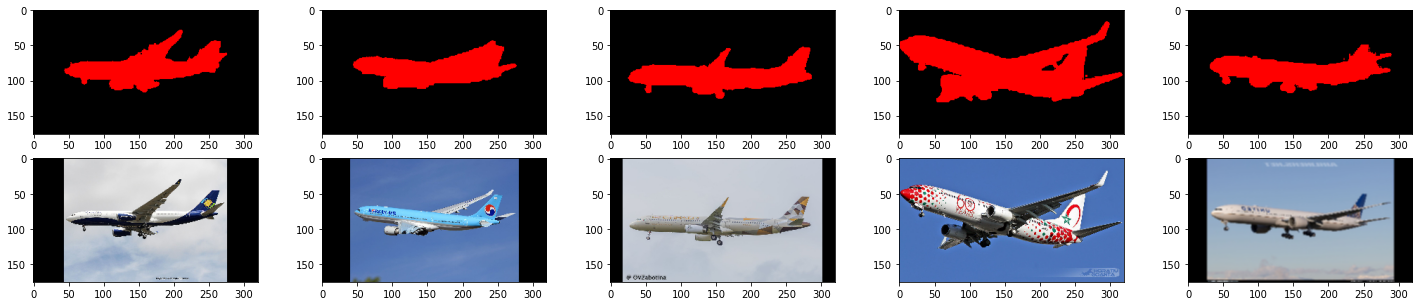

In [214]:
# Тестирование распознования
count = 5 # сколько изображений выводим
n_classes = 2 # количество классов
indexes = np.random.randint(0, len(x_val), count) # Получаем count случайных индексов
fig, axs = plt.subplots(2, count, figsize=(25, 5)) # Создаем полотно из n графиков
for i,idx in enumerate(indexes): # Проходим по всем сгенерированным индексам
  predict = np.array(modelAir.predict(x_val[idx].reshape(1, img_width, img_height, 3))) # Предиктим изображение
  pr = predict[0] # Берем нулевой элемент из перидкта
  pr1 = [] # Пустой лист под сегментированное изображение из predicta
  pr = pr.reshape(-1, n_classes) # Решейпим предикт
  for k in range(len(pr)): # Проходим по всем уровням (количество классов)
    pr1.append(index2color(pr[k])) # Переводим индекс в пиксель
  pr1 = np.array(pr1) # Преобразуем в numpy
  pr1 = pr1.reshape(img_width, img_height,3) # Решейпим к размеру изображения
  img = Image.fromarray(pr1.astype('uint8')) # Получаем изображение из предикта
  axs[0,i].imshow(img.convert('RGBA')) # Отображаем на графике в первой линии
  axs[1,i].imshow(Image.fromarray(x_val[idx].astype('uint8'))) # Отображаем на графике во второй линии оригинальное изображение        
plt.show() 

## PSPNet

In [205]:
def PSPNet(num_classes, input_shape = (img_width, img_height, 3)): # размерность (176, 320, 2)):
    img_input = Input(input_shape)
    # Вытаскиваем карту признаков с первого слоя 
    x = Conv2D(32, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = Activation('relu')(x) 
    x = Conv2D(32, (3, 3), padding='same', name='block1_conv2')(x)
    block_0_out = Activation('relu')(x)  # Первая карта признаков исходного размера

    # исходную карту признаков делим еще на 4 уменьшая каждую карту на 2/4/8/16 раз
    block_1_out = MaxPooling2D((2,2))(block_0_out) 
    block_1_out = BatchNormalization()(block_1_out)

    block_2_out = MaxPooling2D((4,4))(block_0_out) 
    block_2_out = BatchNormalization()(block_2_out)

    block_3_out = MaxPooling2D((8,8))(block_0_out) 
    block_3_out = BatchNormalization()(block_3_out)

    block_4_out = MaxPooling2D((16,16))(block_0_out) 
    block_4_out = BatchNormalization()(block_4_out)

    # вытаскиваем признаки из уменьшенных изображений
    block_1_out = Conv2D(64,(2,2), padding='same', name='block1_conv3')(block_1_out)
    block_1_out = BatchNormalization()(block_1_out)
    block_1_out = Activation('relu')(block_1_out)

    block_2_out = Conv2D(128,(2,2), padding='same', name='block2_conv3')(block_2_out)
    block_2_out = BatchNormalization()(block_2_out)
    block_2_out = Activation('relu')(block_2_out) 

    block_3_out = Conv2D(256,(2,2), padding='same', name='block3_conv3')(block_3_out)
    block_3_out = BatchNormalization()(block_3_out)
    block_3_out = Activation('relu')(block_3_out) 

    block_4_out = Conv2D(512,(2,2), padding='same', name='block4_conv3')(block_4_out)
    block_4_out = BatchNormalization()(block_4_out)
    block_4_out = Activation('relu')(block_4_out)

    # Возвращаем размер уменьшенных изображений к исходному
    block_1_out = Conv2DTranspose(32,(2,2), strides=(2,2), padding='same')(block_1_out)
    block_1_out = Activation('relu')(block_1_out)

    block_2_out = Conv2DTranspose(32,(4,4), strides=(4,4), padding='same')(block_2_out)
    block_2_out = Activation('relu')(block_2_out)

    block_3_out = Conv2DTranspose(32,(8,8), strides=(8,8), padding='same')(block_3_out)
    block_3_out = Activation('relu')(block_3_out)

    block_4_out = Conv2DTranspose(32,(16,16), strides=(16,16), padding='same')(block_4_out)
    block_4_out = Activation('relu')(block_4_out)

    # Объединяем слои
    out = concatenate([block_0_out, block_1_out, block_2_out, block_3_out, block_4_out])
    out = Conv2D(num_classes, (3,3), activation = 'softmax', padding = 'same')(out)

    model = Model(img_input, out) 

    # Компилируем модель 
    model.compile(optimizer=Adam(decay=5e-4),
                  loss='categorical_crossentropy', metrics=[dice_coef])
    
    return model

In [207]:
modelPSPNet = PSPNet(num_classes, (img_width, img_height, 3)) # Создаем модель PSPNet
history = modelPSPNet.fit(x_train, y_train, epochs=30, batch_size=16, validation_data = (x_val, y_val)) # Обучаем модель 

Epoch 1/30
68/68 [==============================] - 10s 122ms/step - loss: 2.2899 - dice_coef: 0.7865 - val_loss: 0.5083 - val_dice_coef: 0.7591
Epoch 2/30
68/68 [==============================] - 8s 111ms/step - loss: 0.2579 - dice_coef: 0.8923 - val_loss: 0.1584 - val_dice_coef: 0.9160
Epoch 3/30
68/68 [==============================] - 8s 111ms/step - loss: 0.2014 - dice_coef: 0.9120 - val_loss: 0.1494 - val_dice_coef: 0.9209
Epoch 4/30
68/68 [==============================] - 8s 112ms/step - loss: 0.2055 - dice_coef: 0.9005 - val_loss: 0.1478 - val_dice_coef: 0.9108
Epoch 5/30
68/68 [==============================] - 8s 112ms/step - loss: 0.1678 - dice_coef: 0.9175 - val_loss: 0.1353 - val_dice_coef: 0.9220
Epoch 6/30
68/68 [==============================] - 8s 111ms/step - loss: 0.1780 - dice_coef: 0.9184 - val_loss: 0.1357 - val_dice_coef: 0.9155
Epoch 7/30
68/68 [==============================] - 8s 111ms/step - loss: 0.1875 - dice_coef: 0.9056 - val_loss: 0.1340 - val_dice_coef

In [208]:
# Функция визуализации сегментированных изображений
def processImage(model, count = 1, n_classes = 2):
  indexes = np.random.randint(0, len(x_val), count) # Получаем count случайных индексов
  fig, axs = plt.subplots(3, count, figsize=(25, 5)) #Создаем полотно из n графиков
  for i,idx in enumerate(indexes): # Проходим по всем сгенерированным индексам
    predict = np.array(model.predict(x_val[idx].reshape(1, img_width, img_height, 3))) # Предиктим картику
    pr = predict[0] # Берем нулевой элемент из перидкта
    pr1 = [] # Пустой лист под сегментированную картинку из predicta
    pr2 = [] # Пустой лист под сегменитрованную картинку из yVal
    pr = pr.reshape(-1, n_classes) # Решейпим предикт
    yr = y_val[idx].reshape(-1, n_classes) # Решейпим yVal
    for k in range(len(pr)): # Проходим по всем уровням (количесвто классов)
      pr1.append(index2color(pr[k])) # Переводим индекс в писксель
      pr2.append(index2color(yr[k])) # Переводим индекс в писксель
    pr1 = np.array(pr1) # Преобразуем в numpy
    pr1 = pr1.reshape(img_width, img_height,3) # Решейпим к размеру изображения
    pr2 = np.array(pr2) # Преобразуем в numpy
    pr2 = pr2.reshape(img_width, img_height,3) # Решейпим к размеру изображения
    img = Image.fromarray(pr1.astype('uint8')) # Получаем картику из предикта
    axs[0,i].imshow(img.convert('RGBA')) # Отображаем на графике в первой линии
    axs[1,i].imshow(Image.fromarray(pr2.astype('uint8'))) # Отображаем на графике во второй линии сегментированное изображение из yVal
    axs[2,i].imshow(Image.fromarray(x_val[idx].astype('uint8'))) # Отображаем на графике в третьей линии оригинальное изображение        
  plt.show()  

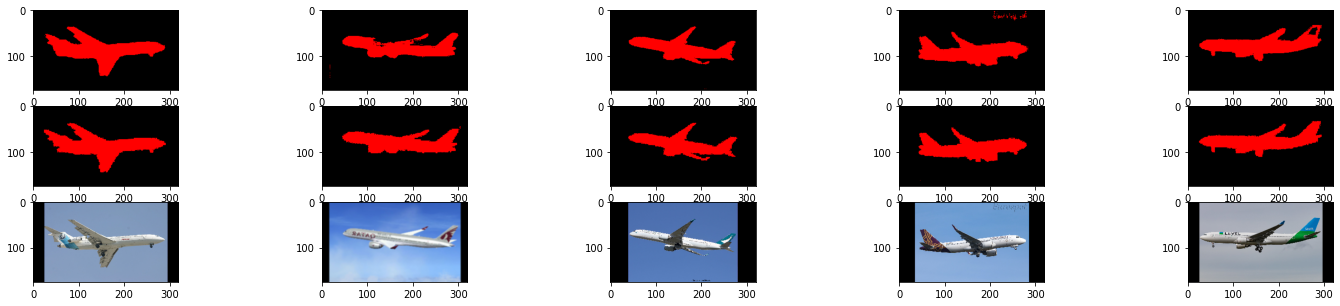

In [213]:
processImage(modelPSPNet, 5, num_classes)

В данной задаче сеть Unet показала себя лучше чем PSPNet